In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score as NMI

%matplotlib inline
from numba import njit

In [4]:
import sys
sys.path.insert(1, "../utilities")
from plot_utils import *
from extract import *
from assigners import *
from effect_estimators import *
from experimental import *

In [6]:
@njit(parallel=True)
def kmeans(X, k, n_iter, init_centroids):
    #Fast parallel kmeans
    #Original implementation from old numba examples (here slightly modified)
    N = X.shape[0]
    D = X.shape[1]
    centroids = init_centroids
    
    for l in range(n_iter):
        dist = np.array([[np.sqrt(np.sum((X[i, :] - centroids[j, :])**2))
                                for j in range(k)] for i in range(N)])

        predictions = np.array([dist[i, :].argmin() for i in range(N)])
            
        centroids = np.array([[np.sum(X[predictions == i, j])/np.sum(predictions == i)
                                 for j in range(D)] for i in range(k)])

    return centroids, dist, predictions




@njit(parallel=True)
def kmeans_spherical(X, k, n_iter, init_centroids):
    #Fast parallel spherical kmeans
    #Original implementation from old numba examples (here slightly modified)
    
    N = X.shape[0]
    D = X.shape[1]
    centroids = init_centroids
    
    for i in range(centroids.shape[0]):
        centroids[i,:] = centroids[i,:]/np.sqrt(centroids[i,:]@centroids[i,:])
    
    for l in range(n_iter):
        dist = 1 - X@centroids.T
        
        predictions = np.array([dist[i, :].argmin() for i in range(N)])
            
        centroids = np.array([[np.sum(X[predictions == i, j])/np.sum(predictions == i)
                                 for j in range(D)] for i in range(k)])
        
        for i in range(centroids.shape[0]):
            centroids[i,:] = centroids[i,:]/np.sqrt(centroids[i,:]@centroids[i,:])

    return centroids, dist, predictions


In [5]:
def get_masstimes(mass_time, inds=None):
    if inds is None:
        inds = np.arange(mass_time.shape[0])
    masstime = np.empty((len(inds),), dtype=object)
    for i, ind in enumerate(inds):
        masstime[i]=mass_time[ind,0] + "@" + mass_time[ind,1]
    return masstime


def map_cluster_ids(df, df_cluster, mt_col=' masstime', c_col=' clusterID'):
    df_new=df.copy()
    for row in range(df_new.shape[0]):
        mt = df_new.loc[row,mt_col]
        ind = np.where(df_cluster[mt_col]==mt)[0]
        label = df_cluster.loc[ind,c_col]
        df_new.at[row,c_col] = label
    return df_new

In [6]:
fnum=0

# Data
pathGF = "../../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
df_GF = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

# Significance information
path_s = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_s = pd.read_csv(path_s + filenames_s[fnum],sep=';')

path_out = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/experimental/"

tle = filenamesGF[fnum].split('GF')[0]

masstime = np.unique(df_s[' masstime'].to_numpy())
data_significant=get_features(masstime, df_GF, True,[0,1,2])

Area = data_significant.iloc[3:,8:48]
groups = df_GF.iloc[0,8:48]
labels = LabelEncoder().fit_transform(groups)

data_X=data_significant.iloc[3:,:48]

cellsRPnegGFstatus.csv
cellsRPnegALPHA0.05FC1.0MINVAR0.125.csv


In [7]:
#sorted_ind=np.argsort(data_significant.iloc[3:,5])
#data_significant=data_significant.iloc[sorted_ind+3,:]
data_X.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
5,Reduced Glutathione,C10 H17 N3 O6 S,2,307.08442,306.07714,0.609,No MS2,[M-H]-1,22.156488084284803,22.424279255395426,...,22.71064097411695,23.75006289012101,23.370456794721267,23.28077131792212,23.620124399449285,22.869467356729697,23.782858059823745,24.00450069571074,23.412271201777354,23.32474683416169
7,Reduced Glutathione,C10 H17 N3 O6 S,1.74,307.08434,306.07706,0.913,No MS2,[M-H]-1,23.251795601807505,23.509163334558792,...,23.348650364674228,24.145229476313656,23.98321476112747,23.632515750033832,23.934705257679628,23.114699904857332,24.167128122163657,24.346850456627738,23.616989477849803,23.821658754447014
23,NaN,C41 H79 N6 O4 P,0.41,750.59035,749.58307,13.067,DDA for preferred ion,[M-H]-1,19.485135752931512,19.115175508065878,...,20.955791068838483,21.216946934774356,20.94104902506037,21.773418968255143,21.358175318797457,21.451483363326126,21.27747290490181,21.4434229388353,21.835035194328622,21.357431965477222
29,O-{[(2R)-3-(Henicosanoyloxy)-2-hydroxypropoxy]...,C27 H54 N O9 P,2.43,567.355,566.34772,10.608,No MS2,[M-H]-1,20.376913029563156,20.259040101217156,...,20.845448413429477,21.140612660787443,20.72939852877524,20.492011192215823,20.609273921253966,20.12665485359071,20.553430253620963,20.905394795962863,20.50127545808506,21.11722068147598
38,NaN,C44 H82 N5 O5 P,0.73,791.60593,790.59866,14.324,DDA for preferred ion,[M-H]-1,19.722912988852563,19.161734657442842,...,21.59705324861394,21.808809909480946,21.42590457184678,22.1948231303575,21.590711350770547,21.810683290718035,21.53910283160454,21.959393562251595,22.3163521881364,22.190049863255602


### Correlation distance CD $\in$ [0,2]

**Value 0 corresponds to fully positively correlated features (cor=1), value 2 fully negatively correlated features (cor=-1). Values close to 1 are uncorrelated.**

In [8]:
X=data_X.iloc[:,8:].to_numpy(dtype=float).T

# Correlation matrix with ddof=0 (just holding a fixed rule)
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(X)
cov_mat =np.cov(X_std.T)
COR = np.cov(X_std.T, ddof=0)

# Make a distance matrix from the correlation matrix COR
mask = np.ones_like(COR) # change mask e.g., to account for temporal proximity
CD = 1 - mask*COR
# make sure the diagonal is zero and the matrix is PD
CD = np.maximum(CD, CD.T)
CD -= np.diag(CD.diagonal())
CD=np.clip(CD,0,2)
cd_matrix = squareform(CD,force='tovector')

print(tle, 'data has',X.shape[1], ' features')
print('\nRange of values in cor-dist:', CD.min(),'-',np.round(CD.max(),2))

cellsRPneg data has 56  features

Range of values in cor-dist: 0.0 - 1.97


### A rough visualization of clustering tendency based on cor-dist

**Can typically recognize 2 main structures corresponding to typical test patterns: typically majority of the form (aSYN,UT) low, (IFNg, comb) high, and minority (aSYN,UT) high, (IFNg, comb) low. These two patterns are negatively correlated.**

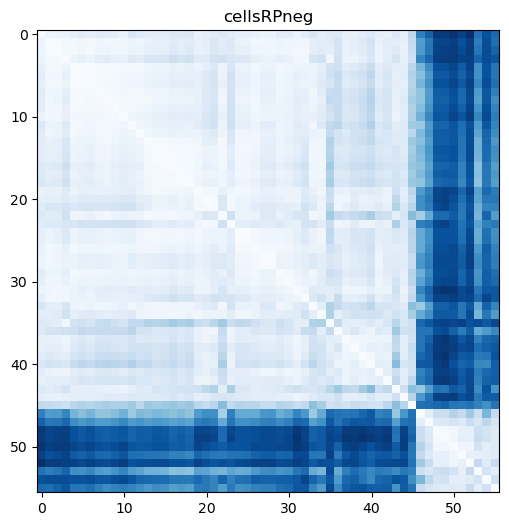

NameError: name 'pyclustertend' is not defined

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(VAT(CD), cmap='Blues')
plt.title(tle)
plt.show()
pyclustertend.vat(CD, figure_size=(6,6))
plt.title(tle)
plt.show()

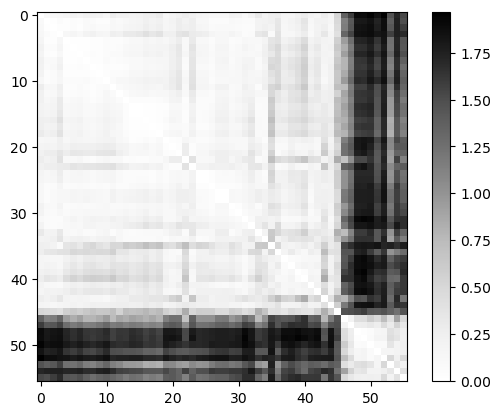

In [8]:
fig, ax =plt.subplots(ncols=1)
pos=ax.imshow(VAT(CD), cmap='Greys')
fig.colorbar(pos, ax=ax)
plt.show()

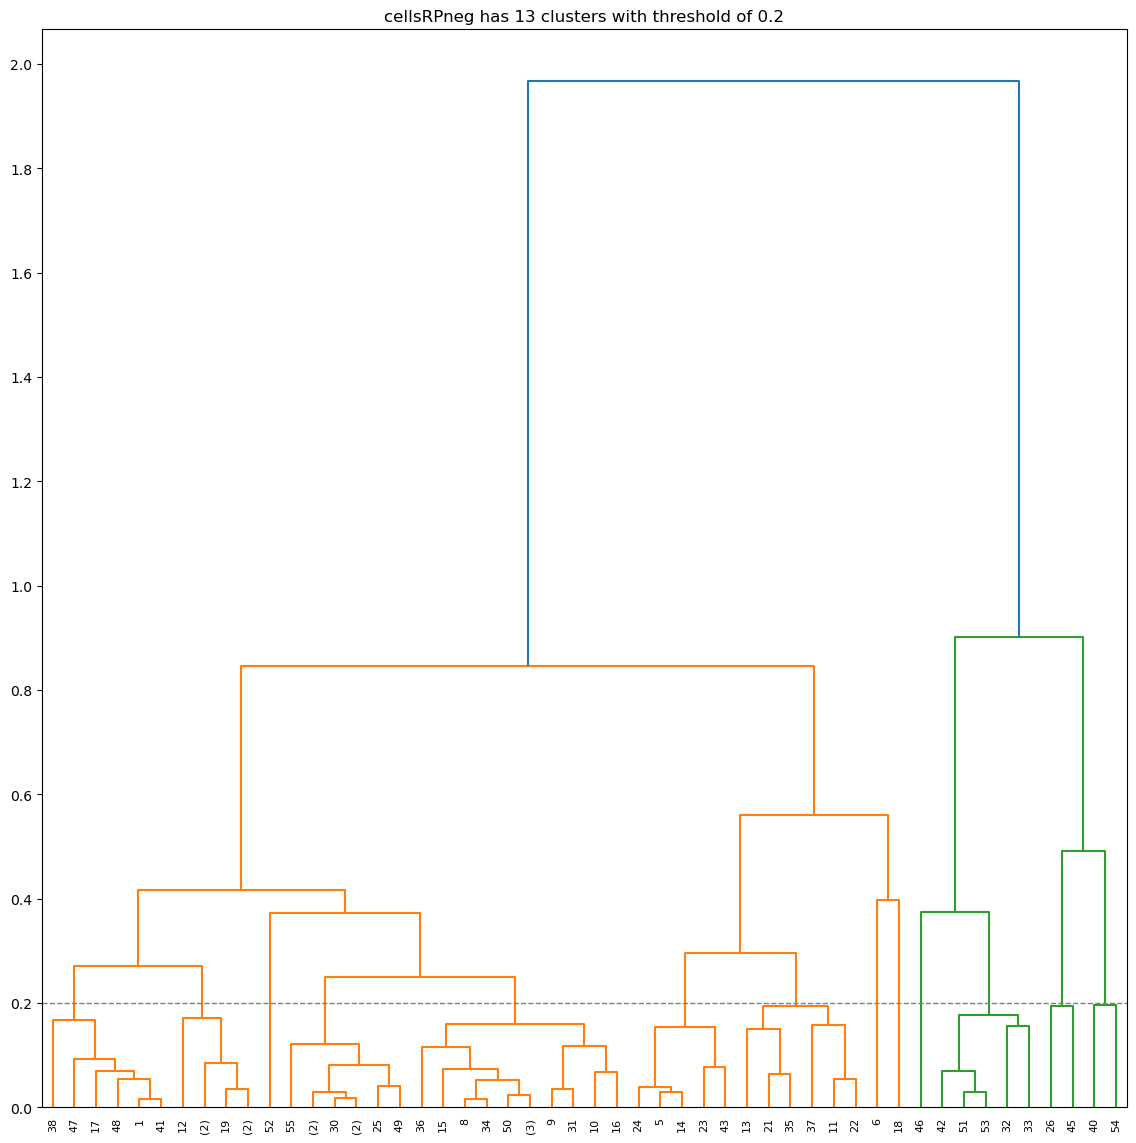

In [9]:
th=0.2
plt.figure(figsize=(14,14))
link_complete = hierarchy.linkage(cd_matrix, method='complete',  optimal_ordering=False)
labels_complete=hierarchy.fcluster(link_complete, t=th, criterion='distance')
hierarchy.dendrogram(link_complete, truncate_mode='lastp', p=50, labels=np.asarray(np.arange(CD.shape[0])))
plt.axhline(y=th, c='grey', lw=1, linestyle='dashed')
plt.yticks(np.arange(0,2.1,0.2))
plt.title("{} has {} clusters with threshold of {}".format(tle, np.unique(labels_complete).shape[0], th))
plt.show()

In [10]:
len(np.unique(labels_complete))

13

In [11]:
old_labels_complete=labels_complete
old_labels_complete

array([ 4,  1,  3,  2,  3,  6,  8,  2,  4,  4,  4,  7,  2,  7,  6,  4,  4,
        1,  9,  2,  4,  7,  7,  6,  6,  3, 12,  4,  3,  2,  3,  4, 10, 10,
        4,  7,  4,  7,  1,  3, 13,  1, 10,  6,  2, 12, 11,  1,  1,  3,  4,
       10,  5, 10, 13,  3], dtype=int32)

### Compile the assignments and update the dataframe with significant features

In [18]:
# Make a copy of the significance data
df_temp=df_s.copy()
df_temp.insert(1, ' clusterID', np.zeros((df_s.shape[0]),dtype=int))

# Make cluster assignment dataframe
clustered_features = pd.DataFrame({' masstime':get_masstimes(data_X.iloc[:,4:6].to_numpy()),
                                   ' clusterID':labels_complete})

In [19]:
# Map the assignments and make a new dataframe
df_new=map_cluster_ids(df_temp, clustered_features)
df_new.head(10)

,compound,clusterID,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
0,D-(+)-Tryptophan,10,203.08233@2.933,comb.--UT,0.0,0.000000,0.000000,-4.431005,3.610911,0,0
1,D-(+)-Tryptophan,10,203.08233@2.933,aSYN--comb.,0.0,0.000000,0.000000,4.747226,3.783463,0,0
2,"[(2R,3S,4R,5R)-5-(6-Amino-9H-purin-9-yl)-3,4-d...",2,558.06513@0.598,comb.--UT,0.0,0.000000,0.000000,5.735628,4.723783,0,6
3,"[(2R,3S,4R,5R)-5-(6-Amino-9H-purin-9-yl)-3,4-d...",2,558.06513@0.598,aSYN--comb.,0.0,0.000000,0.000000,-5.641455,3.859271,7,0
4,D-(+)-Tryptophan,10,203.08233@2.933,aSYN--INFg,0.0,0.000000,0.000000,4.624380,3.170385,0,0
5,"[(2R,3S,4R,5R)-5-(6-Amino-9H-purin-9-yl)-3,4-d...",2,558.06513@0.598,aSYN--INFg,0.0,0.000000,0.000000,-5.416290,2.784305,7,0
6,D-(+)-Tryptophan,10,203.08233@2.933,INFg--UT,0.0,0.000000,0.000000,-4.308160,2.997833,0,0
7,NaN,10,524.33683@10.692,aSYN--INFg,0.0,0.000001,0.000001,2.559779,1.251014,0,0
8,"[(2R,3S,4R,5R)-5-(6-Amino-9H-purin-9-yl)-3,4-d...",2,558.06513@0.598,INFg--UT,0.0,0.000001,0.000001,5.510464,3.648817,0,6
9,NaN,10,524.33683@10.692,INFg--UT,0.0,0.000002,0.000003,-2.724524,1.345622,0,0


### Write new results

In [371]:
#df_new.to_csv(path_out + fname, sep=';', index=None)

### Checks

In [20]:
k=luniq[0]
clustered_features.iloc[np.where(clustered_features[' clusterID']==k)[0],:]

,masstime,clusterID
1,306.07706@0.913,1
17,133.01332@0.61,1
38,323.07971@0.562,1
41,653.1407@0.862,1
47,530.05715@0.897,1
48,635.14339@0.912,1


In [21]:
df_new.iloc[np.where(df_new[' clusterID']==k)[0],:]

,compound,clusterID,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
15,Reduced Glutathione,1,306.07706@0.913,aSYN--comb.,0.000000,0.000232,0.000443,-1.190763,0.273846,0,0
16,NaN,1,635.14339@0.912,aSYN--comb.,0.000000,0.000232,0.000480,-1.922021,0.469243,0,0
18,Reduced Glutathione,1,306.07706@0.913,comb.--UT,0.000000,0.000414,0.001043,1.199859,0.204553,0,0
21,NaN,1,653.1407@0.862,comb.--UT,0.000001,0.000509,0.001585,2.058949,0.469270,0,0
22,NaN,1,635.14339@0.912,aSYN--INFg,0.000001,0.000815,0.002772,-1.641015,0.429227,0,0
23,NaN,1,653.1407@0.862,aSYN--comb.,0.000001,0.000865,0.003050,-2.150083,0.761639,0,0
26,NaN,1,323.07971@0.562,aSYN--comb.,0.000002,0.000970,0.004363,-2.204715,0.265748,3,0
27,NaN,1,635.14339@0.912,comb.--UT,0.000002,0.000976,0.004507,2.245379,0.369241,0,0
28,NaN,1,323.07971@0.562,comb.--UT,0.000002,0.000993,0.004783,2.035897,0.022643,0,0
29,NaN,1,530.05715@0.897,comb.--UT,0.000002,0.000993,0.004882,3.934630,1.285213,0,6


### Visualize individual clusters

In [22]:
inds=np.argsort(labels_complete)
result = data_X.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=labels_complete[inds])
luniq=np.unique(labels_complete[inds])

In [23]:
k=luniq[0]

cluster_ind = np.where(labels_complete[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[0.862 0.913 0.61  0.912 0.897 0.562]


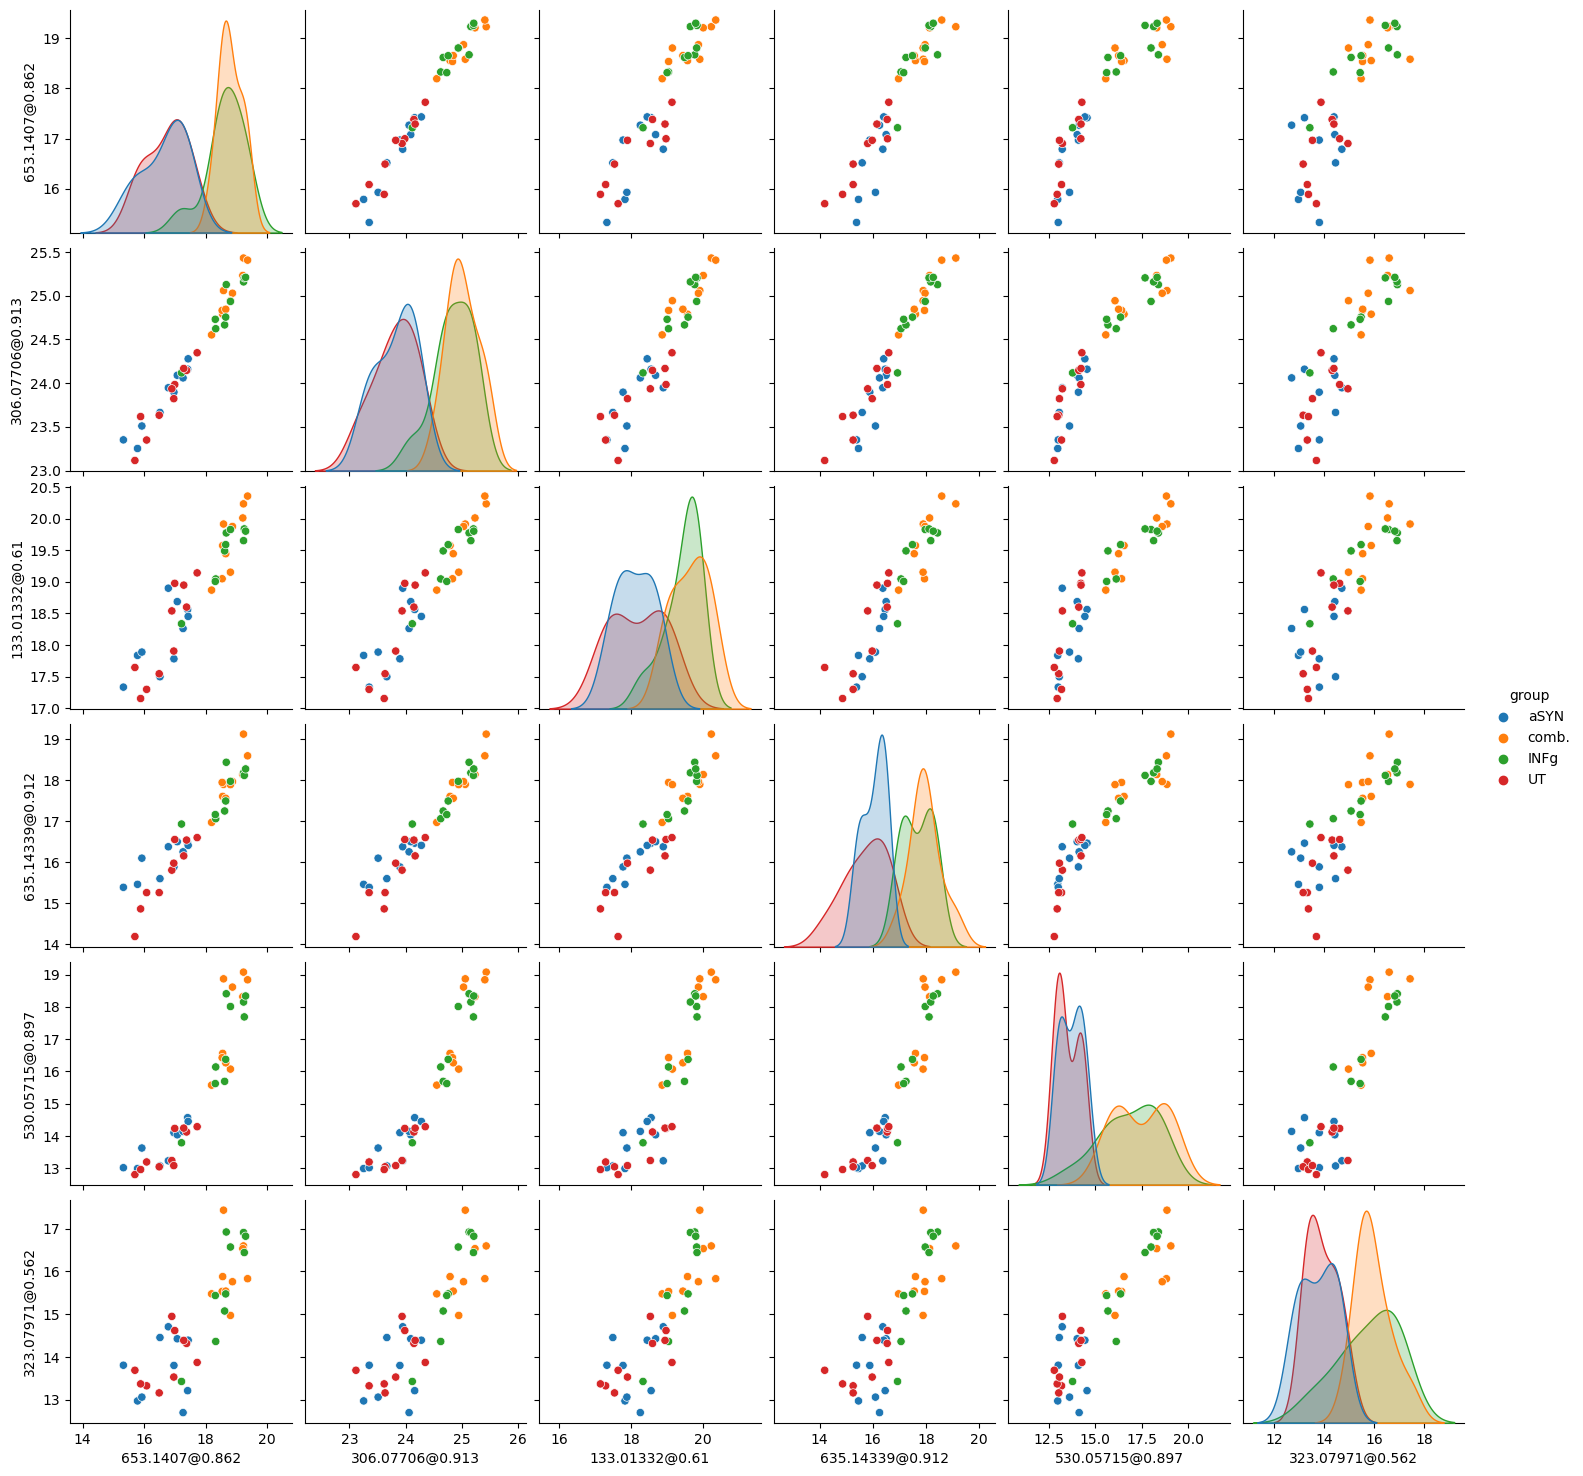

In [19]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

In [24]:
df_new.iloc[np.where(df_new[' clusterID']==k)[0],:]

,compound,clusterID,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
15,Reduced Glutathione,1,306.07706@0.913,aSYN--comb.,0.000000,0.000232,0.000443,-1.190763,0.273846,0,0
16,NaN,1,635.14339@0.912,aSYN--comb.,0.000000,0.000232,0.000480,-1.922021,0.469243,0,0
18,Reduced Glutathione,1,306.07706@0.913,comb.--UT,0.000000,0.000414,0.001043,1.199859,0.204553,0,0
21,NaN,1,653.1407@0.862,comb.--UT,0.000001,0.000509,0.001585,2.058949,0.469270,0,0
22,NaN,1,635.14339@0.912,aSYN--INFg,0.000001,0.000815,0.002772,-1.641015,0.429227,0,0
23,NaN,1,653.1407@0.862,aSYN--comb.,0.000001,0.000865,0.003050,-2.150083,0.761639,0,0
26,NaN,1,323.07971@0.562,aSYN--comb.,0.000002,0.000970,0.004363,-2.204715,0.265748,3,0
27,NaN,1,635.14339@0.912,comb.--UT,0.000002,0.000976,0.004507,2.245379,0.369241,0,0
28,NaN,1,323.07971@0.562,comb.--UT,0.000002,0.000993,0.004783,2.035897,0.022643,0,0
29,NaN,1,530.05715@0.897,comb.--UT,0.000002,0.000993,0.004882,3.934630,1.285213,0,6


In [25]:
cluster_names

array(['nan', 'Reduced Glutathione', 'nan', 'nan', 'nan', 'nan'],
      dtype='<U19')

In [26]:
cluster_masstimes

['653.1407@0.862',
 '306.07706@0.913',
 '133.01332@0.61',
 '635.14339@0.912',
 '530.05715@0.897',
 '323.07971@0.562']

In [27]:
mts, ps, ts, es = extract_pvalues(df_s,cluster_masstimes, pvalue_col=' p_FDR',head='')
display_pvalues(mts, ps, ts, es, tle)

cellsRPneg
-----------------------
Peak: 653.1407@0.862
P-values: [0.000509, 0.000865, 0.001461, 0.001598]
Tests: ['comb.--UT', 'aSYN--comb.', 'INFg--UT', 'aSYN--INFg']
Effects: [2.058949, -2.150083, 1.898145, -1.989279]
-----------------------
Peak: 306.07706@0.913
P-values: [0.000232, 0.000414, 0.001386, 0.001848]
Tests: ['aSYN--comb.', 'comb.--UT', 'aSYN--INFg', 'INFg--UT']
Effects: [-1.190763, 1.199859, -1.031581, 1.040676]
-----------------------
Peak: 133.01332@0.61
P-values: [0.001386, 0.003994, 0.013097, 0.03844]
Tests: ['aSYN--comb.', 'aSYN--INFg', 'comb.--UT', 'INFg--UT']
Effects: [-1.527943, -1.315755, 1.472697, 1.260509]
-----------------------
Peak: 635.14339@0.912
P-values: [0.000232, 0.000815, 0.000976, 0.002738]
Tests: ['aSYN--comb.', 'aSYN--INFg', 'comb.--UT', 'INFg--UT']
Effects: [-1.922021, -1.641015, 2.245379, 1.964373]
-----------------------
Peak: 530.05715@0.897
P-values: [0.000993, 0.001471, 0.007032, 0.010608]
Tests: ['comb.--UT', 'aSYN--comb.', 'INFg--UT', 'aS

## Alternative approach using a mixture of Von Mises Fisher distributions, or spherical kmeans 

In [12]:
#@njit(parallel=True)
def kmeans_spherical(X, k, n_iter, init_centroids):
    #Fast parallel spherical kmeans
    #Original implementation from old numba examples (here slightly modified)
    
    N = X.shape[0]
    D = X.shape[1]
    centroids = init_centroids
    
    for n in range(centroids.shape[0]):
        centroids[n,:] = centroids[n,:]/np.sqrt(centroids[n,:]@centroids[n,:])
    
    for l in range(n_iter):
        dist = 1 - X@centroids.T
        
        predictions = np.array([dist[i, :].argmin() for i in range(N)])
            
        centroids = np.array([[np.sum(X[predictions == i, j])/np.sum(predictions == i)
                                 for j in range(D)] for i in np.unique(predictions)])#range(k)])
        
        for n in range(centroids.shape[0]):
            centroids[n,:] = centroids[n,:]/np.sqrt(centroids[n,:]@centroids[n,:])

    return centroids, dist, predictions



In [20]:
x=X_std.T
K=23
xinit=x[np.random.choice(range(x.shape[0]),K),:]

In [22]:
centroids, dist, predictions = kmeans_spherical(x, K, 1000, xinit)

In [23]:
predictions

array([17, 15, 11,  2, 11, 13,  2, 11,  4,  9,  9, 10, 15,  2, 13,  8, 14,
       15, 15,  4, 17, 10, 10, 13, 11,  3,  6, 17, 11,  2, 11,  9, 16, 16,
        8, 10,  4, 10, 15, 11, 12,  8, 16, 13, 11,  6,  1, 15, 15, 18, 17,
        7,  0,  5, 12, 11], dtype=int64)

In [24]:
labels_complete

array([ 4,  1,  3,  2,  3,  6,  8,  2,  4,  4,  4,  7,  2,  7,  6,  4,  4,
        1,  9,  2,  4,  7,  7,  6,  6,  3, 12,  4,  3,  2,  3,  4, 10, 10,
        4,  7,  4,  7,  1,  3, 13,  1, 10,  6,  2, 12, 11,  1,  1,  3,  4,
       10,  5, 10, 13,  3], dtype=int32)

In [17]:
NMI(labels_complete, predictions)

0.7417142131275845

In [25]:
inds=np.argsort(predictions)
result = data_X.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=predictions[inds])
luniq=np.unique(predictions[inds])

In [35]:
k=luniq[6]

cluster_ind = np.where(predictions[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[14.091 13.042]


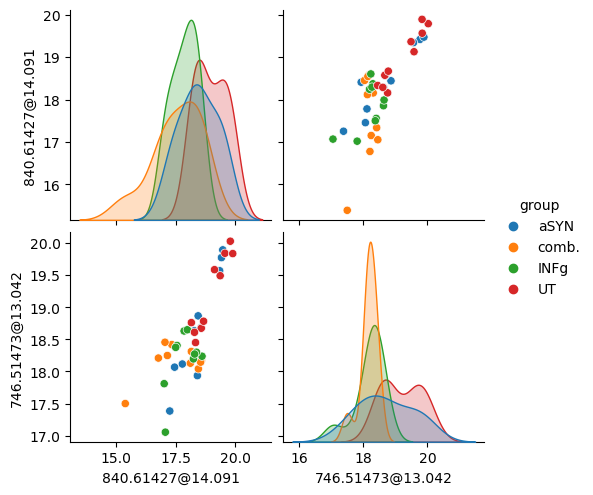

In [36]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)